# Introduction
This project is developed for exploration and learning purposes. The main objective is to experiment with multiple vector stores enriched with metadata, aiming to optimize document retrieval and grading in a downstream application. The smallest vector stores are designed to contain minimal text but maximize the amount of useful information, enabling efficient and precise search results.

This approach closely resembles LangChain's multi-vectorstore implementation but offers advantages in terms of memory usage and speed, operating nearly as fast as a single retriever. In this setup, the documents benefit from well-structured and informative filenames, which facilitate metadata extraction. For less structured documents, it is recommended to identify essential metadata fields to create highly informative, concise document representations for the vector stores by concatenating those fields into a single page content.

Compared to retrieval-augmented generation (RAG) methods that prepend metadata in front of full documents (which may lead to hallucination by large language models due to excessive text), this approach minimizes hallucination risks by limiting the text length. The application retrieves only small, relevant documents identified by unique identifiers, resulting in fast and accurate responses. Moreover, metadata allows easy filtering and opens opportunities for advanced retrieval strategies, where an LLM can decide dynamically which metadata to use for improved effectiveness. This modular design offers great flexibility and scalability for future enhancements.

# Įvadas
Šis projektas sukurtas tyrinėjimo ir mokymosi tikslais. Pagrindinis tikslas – eksperimentuoti su keliais metaduomenimis praturtintais vektorių saugyklomis, siekiant optimizuoti dokumentų paiešką ir vertinimą tolimesnėje programoje. Mažiausios vektorių saugyklos yra kuriamos taip, kad jose būtų kuo mažiau teksto, bet maksimaliai daug naudingos informacijos, kas leidžia efektyviai ir tiksliai rasti reikiamus dokumentus.

Šis požiūris yra panašus į LangChain daugiavektorių saugyklų įgyvendinimą, tačiau turi pranašumų atminties naudojimo ir greičio atžvilgiu, veikdamas beveik taip pat greitai kaip vienas paieškos variklis. Šiame sprendime dokumentai naudoja gerai struktūruotus ir informatyvius failų pavadinimus, kurie palengvina metaduomenų išgavimą. Blogiau pavadintų dokumentų atveju rekomenduojama identifikuoti svarbiausius metaduomenų laukus ir sujungti juos į vieną turinį, kad būtų sukurtos kuo informatyvesnės ir glaustesnės dokumentų reprezentacijos vektorių saugykloms.

Palyginti su RAG (retrieval-augmented generation) metodais,kaip "Path-Rag" kurie metaduomenis deda prieš visą dokumentą (kas pagerina veikima, bet vistiek gali sukelti didžiųjų kalbos modelių halucinacijas dėl pernelyg ilgo teksto), šis metodas sumažina halucinacijų riziką, ribodamas teksto ilgį. Programa atlieka paiešką tik mažose, aktualiose dokumentų dalyse, identifikuotose pagal unikalius identifikatorius, todėl užtikrinamas greitas ir tikslus atsakymas. Be to, metaduomenys leidžia lengvai filtruoti dokumentus ir suteikia galimybę taikyti pažangias paieškos strategijas, kai LLM dinamiškai nusprendžia, kokius metaduomenis naudoti efektyvesniam rezultatui. Toks modulinis dizainas suteikia didelį lankstumą ir pritaikomumą ateities plėtrai. Kai identifikuojami maži dokumentai tinkami, tada išgaunami ir pilni dokumentai, atsakymams gauti.

In [1]:
%%capture --no-display
import os
import shutil
from typing_extensions import TypedDict, List
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from IPython.display import Image, display
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph
from langchain.prompts import PromptTemplate
import uuid
import sys
from langchain_groq import ChatGroq
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph
from langchain_community.document_loaders.directory import DirectoryLoader
from langchain.document_loaders import TextLoader
from pathlib import Path
from langchain_text_splitters import CharacterTextSplitter
from pydantic import BaseModel
import re
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_community.document_loaders.directory import DirectoryLoader
import pandas as pd
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
import fitz  
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### To use this notebook, please paste your API keys below. Optionally, enable Langsmith tracing where AI models are used.
### Norėdami naudotis šia Jupyter užrašine, įveskite savo API raktus žemiau.  Jei norite, įjunkite Langsmith resursu ir eigos sekimą ten, kur naudojami DI modeliai.

In [3]:
os.environ["LANGCHAIN_API_KEY"] = ''
os.environ["LANGCHAIN_TRACING_V2"]="false"
os.environ["LANGCHAIN_ENDPOINT"]= "https://api.langchain.plus"
os.environ["LANGCHAIN_PROJECT"] = ""
os.environ["GROQ_API_KEY"] = ''

## Loading PDF documents from a folder and initializing them as LangChain documents for subsequent preprocessing.
## Įkeliami PDF dokumentai iš aplanko ir inicializuojami LangChain dokumentai tolesniam apdorojimui.

In [4]:
import os
import fitz  
from langchain.schema import Document

folder_path = 'data'

pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]

documents = []

for pdf_file in pdf_files:
    pdf_path = os.path.join(folder_path, pdf_file)
    text = ""
    
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text()
    
    document = Document(
        page_content=text,
        metadata={"Dokumento_pavadinimas": pdf_file}
    )
    documents.append(document)


print(documents[0].metadata)
print(documents[0].page_content[:500])

{'Dokumento_pavadinimas': 'Aukštabalio g. 4, Šiauliai Įėjimo laiptų remontas.pdf'}
 
 
 
 
SKELBIMAS PATEIKTI PASIŪLYMĄ 
2025-05-28  
V24-0218517-29 
 
1. 
Užsakovas: UAB Mano Būstas Šiauliai įmonės kodas 144619514 
 
2. 
Objektas: Aukštabalio g. 4, Šiauliai 
 
3. 
Teiktinų paslaugų arba atliktinų darbų pobūdis: 
                         Įėjimo laiptų, aikštelių remontas. 
 
4. 
Pateiktų dokumentų pavadinimai kainai paskaičiuoti: 
4.1. 
Kiekių žiniaraštis, defektinis aktas Nr. DA611289 
 
5. 
Numatoma darbų/paslaugų pradžios data: 2025 m. III-IV ketvirtis  
 
6. 
Konkurso sąly


### Showing an example of a loaded document
### Rodymas įkelto dokumento pavyzdžio

In [5]:
documents[9]

Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Liepų g. 28, Klaipėda, dėl stogo remonto darbų.pdf'}, page_content=' \n \n \nSKELBIMAS PATEIKTI PASIŪLYMĄ \n2025-05-27 \n \n \n1. \nUžsakovas: UAB Mano Būstas Baltija įmonės kodas  140514359 \n \n2. \nObjektas: Liepų g.   28, Klaipėda \n \n3. \nTeiktinų paslaugų arba atliktinų darbų pobūdis: \n3.1. Stogo remonto darbai \n \n4. \nPateiktų dokumentų pavadinimai kainai paskaičiuoti: \n4.1. \nNUMATOMŲ ATLIKTI DARBŲ ir DEFEKTAVIMO AKTAS  \n5. \nKonkurso sąlygos: \n5.1. Vadovaujantis Lietuvos Respublikos teisės aktais, darbai turi būti atliekami kokybiškai ir suteikiant jiems \ngarantiją. \n5.2. Pasiūlymo galiojimo terminas 3 mėnesiai.  \n5.3. Darbų eigą ir atlikimą pagal atskirą susitarimą fiksuoti per Administratoriaus nurodytą sistemą (e-Paskyra). \n5.4. Siekiant užtikrinti Rangovo garantinių įsipareigojimų tinkamą vykdymą, taikomos šios sąlygos: \n5.4.1. Kai Rangovo pasiūlymo kaina yra iki 3000 Eur be PVM, g

### Preprocessing documents by truncating content before the text "Priedas nr.1". Not all documents contain this text, but tables start after this line and are not needed for this project.
### Apdorojami dokumentai – apkarpomas turinys iki teksto „Priedas nr.1“. Ne visi dokumentai turi šį tekstą, tačiau po jo prasideda lentelės, kurios nėra reikalingos šiam projektui

In [6]:
def cut_before_priedas(text: str) -> str:
    marker = "Priedas Nr. 1."
    index = text.find(marker)
    if index != -1:
        return text[:index].rstrip()  # everything before the marker
    return text

def preprocess_documents(docs: List[Document]) -> List[Document]:
    processed_docs = []
    for doc in docs:
        new_content = cut_before_priedas(doc.page_content)
        processed_docs.append(Document(page_content=new_content, metadata=doc.metadata))
    return processed_docs

In [7]:
processed_docs = preprocess_documents(documents)

### Showing an example after preprocessing — the document is now significantly shorter.
### Rodymas pavyzdžio po apdorojimo – šis konkretus dokumentas tapo žymiai trumpesnis.

In [8]:
processed_docs[9]

Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Liepų g. 28, Klaipėda, dėl stogo remonto darbų.pdf'}, page_content=' \n \n \nSKELBIMAS PATEIKTI PASIŪLYMĄ \n2025-05-27 \n \n \n1. \nUžsakovas: UAB Mano Būstas Baltija įmonės kodas  140514359 \n \n2. \nObjektas: Liepų g.   28, Klaipėda \n \n3. \nTeiktinų paslaugų arba atliktinų darbų pobūdis: \n3.1. Stogo remonto darbai \n \n4. \nPateiktų dokumentų pavadinimai kainai paskaičiuoti: \n4.1. \nNUMATOMŲ ATLIKTI DARBŲ ir DEFEKTAVIMO AKTAS  \n5. \nKonkurso sąlygos: \n5.1. Vadovaujantis Lietuvos Respublikos teisės aktais, darbai turi būti atliekami kokybiškai ir suteikiant jiems \ngarantiją. \n5.2. Pasiūlymo galiojimo terminas 3 mėnesiai.  \n5.3. Darbų eigą ir atlikimą pagal atskirą susitarimą fiksuoti per Administratoriaus nurodytą sistemą (e-Paskyra). \n5.4. Siekiant užtikrinti Rangovo garantinių įsipareigojimų tinkamą vykdymą, taikomos šios sąlygos: \n5.4.1. Kai Rangovo pasiūlymo kaina yra iki 3000 Eur be PVM, g

### Checking document lengths to ensure all documents are properly preprocessed.
### Tikrinami dokumentų ilgiai, siekiant užtikrinti, kad visi dokumentai būtų tinkamai apdoroti.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.schema import Document  # or your Document class import

def plot_document_lengths(docs: List[Document]):
    lengths = [len(doc.page_content) for doc in docs]
    
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")
    print(f"Average length: {sum(lengths) / len(lengths):.2f}")

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(lengths, bins=20, kde=True, color="skyblue")
    plt.title("Document Character Length Distribution")
    plt.xlabel("Character Count")
    plt.ylabel("Number of Documents")
    plt.show()

Min length: 3489
Max length: 8057
Average length: 4738.72


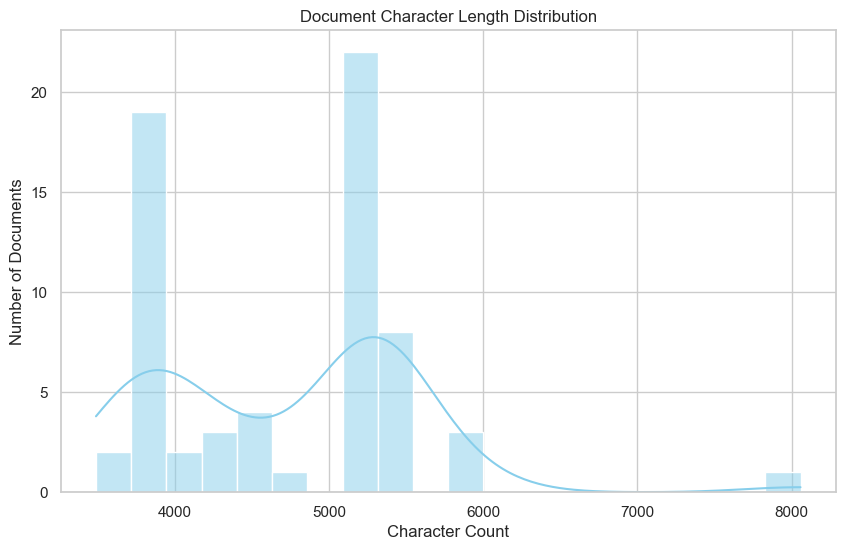

In [10]:
plot_document_lengths(processed_docs)

### One document is exceptionally longer than the others; verifying its preprocessing.
### Vienas dokumentas yra išskirtinai ilgesnis nei kiti; tikrinama jo apdorojimo kokybė

In [11]:
def print_long_documents(docs: List[Document], min_length: int = 7000):
    for doc in docs:
        if len(doc.page_content) > min_length:
            print(doc.page_content)

In [12]:
print_long_documents(processed_docs, 7000)

 
 
 
 
 
SKELBIMAS PATEIKTI PASIŪLYMĄ 
2025-02-06 
 
 
1. 
Užsakovas: UAB Mano Būstas Vakarai įmonės kodas 177000697 
 
2. 
Objektas: Sodų g.    1, Šilutė 
 
3. 
Teiktinų paslaugų arba atliktinų darbų pobūdis: 
3.1. Vidaus šildymo sistemos modernizavimo rangos darbai su projektinės dokumentacijos paruošimu. 
3.2. Pateikiant pasiūlymą išskirti kainas:  
Darbai 
Kaina su PVM 
Projektinės dokumentacijos paruošimas 
 
Vidaus šildymo sistemos modernizavimo rangos 
darbai 
 
Viso:  
 
4. 
Pateiktų dokumentų pavadinimai kainai paskaičiuoti: 
4.1. 1) bendrosios nuosavybės teise valdomų elevatorinių šilumos punktų keitimo į naują automatizuotą 
šilumos punktą ar senų susidėvėjusių automatinių šilumos punktų, kurie automatiškai nepalaiko nustatytos 
karšto vandens temperatūros pastato vidaus karšto vandens tiekimo sistemoje,  atnaujinimo arba atskiro 
šilumos punkto daugiabučiame name įrengimo, įskaitant balansinių ventilių ant šildymo ir karšto vandens 
stovų įrengimo; 2) šildymo sistemos pert

### The longest document is preprocessed as expected. 
### Ilgiausias dokumentas apdorojamas kaip tikėtasi.

## Extracting the application deadline date for projects.
## Ištraukiama projekto paraiškos pateikimo pabaigos data.

In [13]:
import re

def extract_pasiulyma_metadata(text: str):
    # Capture everything after 'Pasiūlymą pateikti iki' up to the first newline (including newlines inside)
    # We'll capture all chars until we hit a newline OR end of string
    pattern = re.compile(
        r'Pasiūlymą pateikti iki\s*(.*?)(?:\n|$)',
        re.IGNORECASE | re.DOTALL
    )
    match = pattern.search(text)
    if match:
        captured = match.group(1).strip()
        # Optionally, normalize whitespace/newlines inside
        captured = ' '.join(captured.split())
        return captured
    return None

def preprocess_documents(docs: list[Document]) -> list[Document]:
    processed_docs = []
    for doc in docs:
        pasiulyma_metadata = extract_pasiulyma_metadata(doc.page_content)

        new_metadata = dict(doc.metadata) if doc.metadata else {}
        if pasiulyma_metadata:
            new_metadata['Pasiulyma_pateikti_iki'] = pasiulyma_metadata

        new_content = doc.page_content  

        processed_docs.append(Document(page_content=new_content, metadata=new_metadata))
    return processed_docs


In [14]:
processed_documents_metadata = preprocess_documents(processed_docs)

In [15]:
processed_documents_metadata[9]

Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Liepų g. 28, Klaipėda, dėl stogo remonto darbų.pdf', 'Pasiulyma_pateikti_iki': '2025-06-11 d. 12 val.'}, page_content=' \n \n \nSKELBIMAS PATEIKTI PASIŪLYMĄ \n2025-05-27 \n \n \n1. \nUžsakovas: UAB Mano Būstas Baltija įmonės kodas  140514359 \n \n2. \nObjektas: Liepų g.   28, Klaipėda \n \n3. \nTeiktinų paslaugų arba atliktinų darbų pobūdis: \n3.1. Stogo remonto darbai \n \n4. \nPateiktų dokumentų pavadinimai kainai paskaičiuoti: \n4.1. \nNUMATOMŲ ATLIKTI DARBŲ ir DEFEKTAVIMO AKTAS  \n5. \nKonkurso sąlygos: \n5.1. Vadovaujantis Lietuvos Respublikos teisės aktais, darbai turi būti atliekami kokybiškai ir suteikiant jiems \ngarantiją. \n5.2. Pasiūlymo galiojimo terminas 3 mėnesiai.  \n5.3. Darbų eigą ir atlikimą pagal atskirą susitarimą fiksuoti per Administratoriaus nurodytą sistemą (e-Paskyra). \n5.4. Siekiant užtikrinti Rangovo garantinių įsipareigojimų tinkamą vykdymą, taikomos šios sąlygos: \n5.4.1. Kai

### Some documents are missing the day in the full date. In those cases, the day is assigned as 28, which is an optimal choice since it corresponds to the shortest month. This also signals users to verify the exact date in the full document, as there is a section specifying when and where to submit applications. it will help in application to filter out expired projects.

###  Kai kuriuose dokumentuose trūksta datos dienos. Tokiais atvejais diena priskiriama 28-ai, kas yra optimalus sprendimas, nes atitinka trumpiausio mėnesio dienų skaičių. Tai taip pat nurodo vartotojams, kad verta patikrinti datą pilname dokumente, kur yra skiltis apie paraiškos pateikimo laiką ir vietą. Tai padės aplikacijoje išfiltruoti nebegaliojančius projektų teikimus.

In [16]:


def fix_incomplete_date(date_str: str, default_day: int = 28) -> str:
    date_str = date_str.strip()
    
    # Try to find date pattern YYYY-MM-DD or partial YYYY-MM
    # If day is missing, add default day
    
    # Match full date YYYY-MM-DD
    full_date_match = re.match(r'^(\d{4})-(\d{2})-(\d{2})', date_str)
    if full_date_match:
        # date complete, return as is with possible trailing time
        return date_str
    
    partial_date_match = re.match(r'^(\d{4})-(\d{2})-?$', date_str)
    if partial_date_match:
        year, month = partial_date_match.groups()
        fixed_date = f"{year}-{month}-{default_day:02d}"
        return fixed_date
    
    # Match partial date YYYY-MM with trailing chars or incomplete day
    partial_date_match2 = re.match(r'^(\d{4})-(\d{2})-', date_str)
    if partial_date_match2:
        year, month = partial_date_match2.groups()
        fixed_date = f"{year}-{month}-{default_day:02d}"
        # Append rest of string after YYYY-MM-
        rest = date_str[len(f"{year}-{month}-"):]
        fixed_date += rest
        return fixed_date
    
    return date_str

def preprocess_documents(docs: List[Document]) -> List[Document]:
    processed_docs = []
    for doc in docs:
        pasiulyma_metadata = extract_pasiulyma_metadata(doc.page_content)

        new_metadata = dict(doc.metadata) if doc.metadata else {}
        if pasiulyma_metadata:
            fixed_date = fix_incomplete_date(pasiulyma_metadata, default_day=28)
            new_metadata['Pasiulyma_pateikti_iki'] = fixed_date

        processed_docs.append(Document(page_content=doc.page_content, metadata=new_metadata))
    return processed_docs

In [17]:
processed_documents_metadata = preprocess_documents(processed_documents_metadata)

In [18]:
processed_documents_metadata[16]

Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Sodų g. 1, Šilutė, dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu.pdf', 'Pasiulyma_pateikti_iki': '2025-02-20 d. 12 val.'}, page_content=' \n \n \n \n \nSKELBIMAS PATEIKTI PASIŪLYMĄ \n2025-02-06 \n \n \n1. \nUžsakovas: UAB Mano Būstas Vakarai įmonės kodas 177000697 \n \n2. \nObjektas: Sodų g.    1, Šilutė \n \n3. \nTeiktinų paslaugų arba atliktinų darbų pobūdis: \n3.1. Vidaus šildymo sistemos modernizavimo rangos darbai su projektinės dokumentacijos paruošimu. \n3.2. Pateikiant pasiūlymą išskirti kainas:  \nDarbai \nKaina su PVM \nProjektinės dokumentacijos paruošimas \n \nVidaus šildymo sistemos modernizavimo rangos \ndarbai \n \nViso:  \n \n4. \nPateiktų dokumentų pavadinimai kainai paskaičiuoti: \n4.1. 1) bendrosios nuosavybės teise valdomų elevatorinių šilumos punktų keitimo į naują automatizuotą \nšilumos punktą ar senų susidėvėjusių automatinių šilumos 

## Initializing the sentence similarity model "intfloat/multilingual-e5-large-instruct," which generates embeddings. This instruct model performs well with the Instruct retriever that will be built on top of the base retriever from the Chroma vector store.
## Inicializuojamas sakinių panašumo modelis "intfloat/multilingual-e5-large-instruct", kuris generuoja įterpimus. Šis instruktuojamas modelis puikiai veikia kartu su Instruct retriveriu, kuris bus sukurtas virš bazinio retriverio iš Chroma vektorių saugyklos.

In [19]:
model_name = "intfloat/multilingual-e5-large-instruct"
model_kwargs = {'device': 'cpu',
                  "trust_remote_code" : 'False'}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )

### Creating a metadata fields extractor using an LLM with structured outputs. The LLM used is "meta-llama/llama-4-maverick-17b-128e-instruct" from the ChatGroq provider.
###  Kuriamas metaduomenų laukų ištraukimų įrankis, naudojant LLM su struktūrizuotais atsakymais. Naudojamas modelis „meta-llama/llama-4-maverick-17b-128e-instruct“ iš ChatGroq tiekėjo.

In [20]:
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

def create_document_metadata_extractor(llm):
    """
    Creates a document metadata extractor using the provided LLM.
    
    Args:
        llm: The language model to be used for extracting metadata.
        
    Returns:
        Callable: A pipeline function that extracts metadata from document titles.
    """
    
    class DocumentMetadata(BaseModel):
        """Structured output for document metadata extraction."""
        Dokumento_tipas: str = Field(
            description="Dokumento tipas: 'Kvietimas', 'Skelbimas', arba 'Nėra'"
        )
        Miestas: str = Field(
            description="Miesto pavadinimas, pvz. 'Vilnius', 'Kaunas', 'Šilutė'",
            default ="Nenurodyta pavadinime"
        )
        Gatvė: str = Field(
            description="Gatvės pavadinimas su numeriu, pvz. 'Taikos g. 15'",
            default ="Nenurodyta pavadinime"
        )
        Kreipiamasi_dėl: str = Field(
            description="Dėl ko kreipiamasi dokumente, pvz. 'dėl fasado ir stogo remonto'",
            default="Nenurodyta"
        )
    
    structured_metadata_extractor = llm.with_structured_output(DocumentMetadata)

    prompt = PromptTemplate(
        template="""Jūs esate dokumentų metaduomenų išgavimo specialistas.
        
Išanalizuokite pateiktą dokumento pavadinimą ir ištraukite šią struktūrinę informaciją:
1. Dokumento_tipas - gali būti "Kvietimas", "Skelbimas" arba "Nėra"
2. Miestas - miesto pavadinimas (Vilnius, Kaunas , Klaipėda , Šilutė , Alytus , Rusnė etc..)
3. Gatvė - gatvės pavadinimas su namo numeriu ( pvz Putinų g. 6 )
4. Kreipiamasi_dėl - dėl ko kreipiamasi dokumente

Dokumento pavadinimas: {document_title}

Pavyzdys:
Jei pavadinimas būtų "Kvietimas pateikti pasiūlymą adresu Taikos g. 15, Šilutė, dėl fasado ir stogo paprastojo remonto"
Rezultatas būtų:
- Dokumento_tipas: Kvietimas
- Miestas: Šilutė
- Gatvė: Taikos g. 15
- Kreipiamasi_dėl: dėl fasado ir stogo paprastojo remonto

Grąžinkite tik struktūruotą informaciją be papildomo teksto.
""",
        input_variables=["document_title"],
    )
    
    metadata_extractor = prompt | structured_metadata_extractor

    return metadata_extractor

In [21]:
import uuid

def enrich_documents_with_metadata(documents, llm):
    """
    Processes documents and enriches them with extracted metadata.
    
    Args:
        documents: List of Document objects with metadata['Dokumento_pavadinimas']
        llm: Language model to use for extraction
    
    Returns:
        List of documents with enriched metadata
    """
    metadata_extractor = create_document_metadata_extractor(llm)
    
    enriched_docs = []
    for doc in documents:
        document_title = doc.metadata.get('Dokumento_pavadinimas', '')
        
        if document_title:
            try:
                extracted_metadata = metadata_extractor.invoke({"document_title": document_title})
                
                new_doc = Document(
                    page_content=doc.page_content,
                    metadata=doc.metadata.copy()
                )


                if 'uuid' not in new_doc.metadata:
                    new_doc.metadata['uuid'] = str(uuid.uuid4())
                
                # Add extracted metadata

                
                new_doc.metadata['Dokumento_tipas'] = extracted_metadata.Dokumento_tipas
                new_doc.metadata['Miestas'] = extracted_metadata.Miestas
                new_doc.metadata['Gatvė'] = extracted_metadata.Gatvė
                new_doc.metadata['Kreipiamasi_dėl'] = extracted_metadata.Kreipiamasi_dėl
                
                enriched_docs.append(new_doc)
                
            except Exception as e:
                print(f"Error processing document {document_title}: {e}")
                enriched_docs.append(doc)
        else:
            enriched_docs.append(doc)
    
    return enriched_docs

### Extracting metadata fields such as City, Street, Work Type, and Document Type.
### Ištraukiami metaduomenys, tokie kaip Miestas, Gatvė, Darbo tipas ir Dokumento tipas.

In [22]:
llm = ChatGroq(
            model="meta-llama/llama-4-maverick-17b-128e-instruct",  
           temperature=0.0,
            max_tokens=200,
            max_retries=3,

        )

In [23]:
enriched_documents = enrich_documents_with_metadata(processed_documents_metadata, llm)



### Example of how the extracted metadata fields appear.
### Pavyzdys, kaip atrodo ištraukti metaduomenys.

In [24]:
for doc in enriched_documents[:3]:
    print(f"Original title: {doc.metadata.get('Dokumento_pavadinimas')}")
    print(f"Dokumento_tipas: {doc.metadata.get('Dokumento_tipas')}")
    print(f"Miestas: {doc.metadata.get('Miestas')}")
    print(f"Gatvė: {doc.metadata.get('Gatvė')}")
    print(f"Kreipiamasi_dėl: {doc.metadata.get('Kreipiamasi_dėl')}")

Original title: Aukštabalio g. 4, Šiauliai Įėjimo laiptų remontas.pdf
Dokumento_tipas: Nėra
Miestas: Šiauliai
Gatvė: Aukštabalio g.4
Kreipiamasi_dėl: Įėjimo laiptų remontas
Original title: Dariaus ir Girėno g. 8, Šiauliai, Stogo, galinių sienų remontas įrengiant apšiltinimą.pdf
Dokumento_tipas: Kvietimas
Miestas: Šiauliai
Gatvė: Dariaus ir Girėno g.8
Kreipiamasi_dėl: Stogo, galinių sienų remontas įrengiant apšiltinimą
Original title: Kvietimas pateikti pasiūlymą adresu Baltijos pr. 47, Klaipėda, dėl 7 laiptinės laiptų pakopų atnaujinimo darbų.pdf
Dokumento_tipas: Kvietimas
Miestas: Klaipėda
Gatvė: Baltijos pr.47
Kreipiamasi_dėl: dėl 7 laiptinės laiptų pakopų atnaujinimo darbų


### Converting documents into a pandas DataFrame for data analysis. Confirming if this approach is appropriate.
### Konvertuojami dokumentai į pandas DataFrame analizei. Patikrinama, ar tai tinkamamas būdas buvo naudojamas gauti metaduomenis.

In [25]:
def metadata_to_dataframe(docs: list) -> pd.DataFrame:
    records = []
    for doc in docs:
        if doc.metadata:
            records.append(doc.metadata)
        else:
            records.append({})
    df = pd.DataFrame(records)
    return df

In [26]:
df_metadata = metadata_to_dataframe(enriched_documents)

In [27]:
df_metadata.head(5)

,Dokumento_pavadinimas,Pasiulyma_pateikti_iki,uuid,Dokumento_tipas,Miestas,Gatvė,Kreipiamasi_dėl
0,"Aukštabalio g. 4, Šiauliai Įėjimo laiptų remon...",2025-06-11 d. 12 val.,f2afcf42-c5e3-444e-bd71-44b5930064de,Nėra,Šiauliai,Aukštabalio g.4,Įėjimo laiptų remontas
1,"Dariaus ir Girėno g. 8, Šiauliai, Stogo, galin...",2025-06-05 d. 12 val.,304d0f4a-a3e8-4ed7-a2ba-e087655ccd03,Kvietimas,Šiauliai,Dariaus ir Girėno g.8,"Stogo, galinių sienų remontas įrengiant apšilt..."
2,Kvietimas pateikti pasiūlymą adresu Baltijos p...,2025-05-12 d. 12 val.,ff781da8-4a31-4d20-b4ee-57556ba1e707,Kvietimas,Klaipėda,Baltijos pr.47,dėl 7 laiptinės laiptų pakopų atnaujinimo darbų
3,Kvietimas pateikti pasiūlymą adresu Baltijos p...,2025-05-28 d. 12 val.,30b315a9-c1c7-4fe3-92ee-6a19e185bfec,Kvietimas,Klaipėda,Baltijos pr.81,dėl Fasado remontas (Siūlių padengimas hermeti...
4,Kvietimas pateikti pasiūlymą adresu Debreceno ...,2025-06-02 d. 12 val.,229e91c1-e005-4fa0-a42a-dc4401415dd2,Kvietimas,Klaipėda,Debreceno g.16,dėl fasado plytų mūro remonto darbų


### No missing values detected, indicating good data preprocessing.
### Trūkstamų reikšmių nėra, tai rodo gerą duomenų apdorojimą.

In [28]:

print(df_metadata.isnull().values.any())


print(df_metadata.isnull().sum())

False
Dokumento_pavadinimas     0
Pasiulyma_pateikti_iki    0
uuid                      0
Dokumento_tipas           0
Miestas                   0
Gatvė                     0
Kreipiamasi_dėl           0
dtype: int64


## Checking the count of all projects across different cities.
## Tikrinamas visų projektų skaičius pagal miestus.

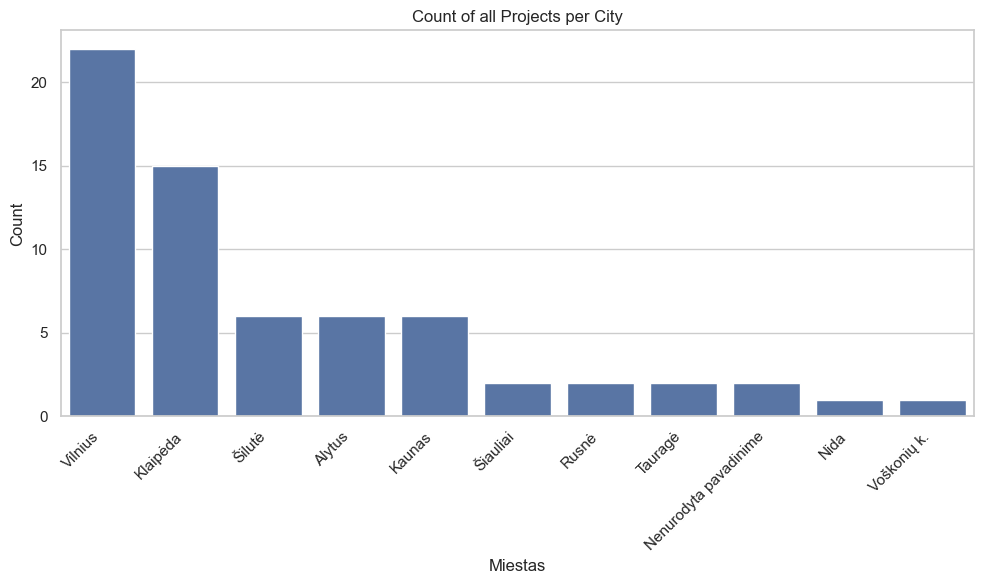

In [29]:
plt.figure(figsize=(10, 6))


sns.countplot(data=df_metadata, x='Miestas', order=df_metadata['Miestas'].value_counts().index)

plt.title('Count of all Projects per City')
plt.xlabel('Miestas')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Most of the projects are in Vilnius , Klaipėda and Šilutė
### Dauguma projektų yra Vilniuje, Klaipėdoje ir Šilutėje.

### Checking all currently available projects for application, by city.
### Tikrinami visi šiuo metu laisvi projektai pagal miestus, kuriuos dar galima pateikti.

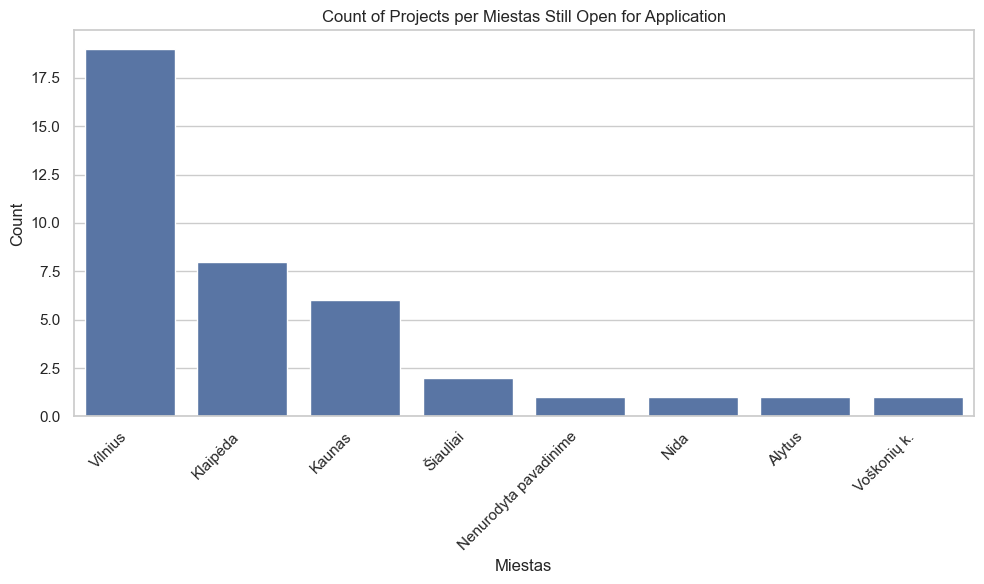

In [30]:
def extract_date(date_str):
    if pd.isna(date_str):
        return None
    try:
        date_part = date_str.strip()[:10]
        return pd.to_datetime(date_part, format='%Y-%m-%d')
    except Exception:
        return None

# Add a new column with parsed date
df_metadata['Pasiulyma_date'] = df_metadata['Pasiulyma_pateikti_iki'].apply(extract_date)


today = pd.to_datetime(datetime.today().date())
df_filtered = df_metadata[df_metadata['Pasiulyma_date'] > today]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered, x='Miestas', order=df_filtered['Miestas'].value_counts().index)
plt.title('Count of Projects per Miestas Still Open for Application')
plt.xlabel('Miestas')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Available projects show different distribution; Kaunas ranks third, and Šilutė currently has no open projects.
### Laisvi projektai rodo kitokią pasiskirstymo struktūrą: Kaunas yra trečioje vietoje, o Šilutėje šiuo metu nėra laisvų projektų.

# Initializing the first vector store, containing documents with full page content. 
# Inicializuojama pirmoji vektorių saugykla, kurioje dokumentai turi pilną turinį.

In [31]:
vectorstores_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'vectorstores')
if not os.path.exists(vectorstores_dir):
    os.makedirs(vectorstores_dir)

In [32]:
persist_directory = os.path.join(vectorstores_dir, 'Mano_BustasPasiulymai_VDidele')

In [33]:
vectorstore  = Chroma.from_documents(documents=enriched_documents, embedding=embeddings, persist_directory=persist_directory,
)

In [34]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3, })

## Testing the base retriever created from the Chroma vector store.
## Testuojamas bazinis retrieveris, sukurtas iš Chroma vektorių saugyklos.

In [35]:
retriever.invoke("Kokiu objektu yra Šilutėje?")

[Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Sodų g. 1, Šilutė, dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu.pdf', 'Dokumento_tipas': 'Kvietimas', 'Gatvė': 'Sodų g.1', 'Kreipiamasi_dėl': 'dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu', 'Miestas': 'Šilutė', 'Pasiulyma_pateikti_iki': '2025-02-20 d. 12 val.', 'uuid': 'a43277cd-251d-466a-94af-7124740d7a72'}, page_content=' \n \n \n \n \nSKELBIMAS PATEIKTI PASIŪLYMĄ \n2025-02-06 \n \n \n1. \nUžsakovas: UAB Mano Būstas Vakarai įmonės kodas 177000697 \n \n2. \nObjektas: Sodų g.    1, Šilutė \n \n3. \nTeiktinų paslaugų arba atliktinų darbų pobūdis: \n3.1. Vidaus šildymo sistemos modernizavimo rangos darbai su projektinės dokumentacijos paruošimu. \n3.2. Pateikiant pasiūlymą išskirti kainas:  \nDarbai \nKaina su PVM \nProjektinės dokumentacijos paruošimas \n \nVidaus šildymo sistemos modernizavimo rangos \ndarb

### Instruct retriever initialization from base retriever
### Inicijuojamas Instruct retriveris, pagrįstas baziniu retrieveriu.

In [36]:
from langchain.schema.retriever import BaseRetriever

def get_detailed_instruct(task_description: str, query: str) -> str:
    """Format a query with a task description to guide the model."""
    return f'Instruct: {task_description}\nQuery: {query}'


class InstructRetriever(BaseRetriever):
    """Retriever that adds instruction to queries before retrieval."""
    
    base_retriever: BaseRetriever = Field(...)
    task_description: str = Field(...)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        """Add instruction to the query before passing to the base retriever."""
        formatted_query = get_detailed_instruct(self.task_description, query)
        return self.base_retriever.invoke(formatted_query)


In [37]:

basic_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})


task_description = "Atrask aktualiausius objektus iš duombazės"


instruct_retriever = InstructRetriever(
    base_retriever=basic_retriever,
    task_description=task_description
)

In [38]:
instruct_retriever.invoke("Kvietimai Vilniuje")

[Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą dėl vandentiekio projekto parengimo darbų, adresu Panerių g. 41, Vilnius.pdf', 'Dokumento_tipas': 'Kvietimas', 'Gatvė': 'Panerių g.41', 'Kreipiamasi_dėl': 'dėl vandentiekio projekto parengimo darbų', 'Miestas': 'Vilnius', 'Pasiulyma_pateikti_iki': '2025-06-09 d. 12 val.', 'uuid': '52950d34-7d6e-4075-8604-0f73ca4bb27a'}, page_content=' \n \n \n \n \nSKELBIMAS PATEIKTI PASIŪLYMĄ \n2025-05-23 \n \n1. \nUžsakovas: UAB Mano Būstas Vilnius įmonės kodas 121452091 \n \n2. \nObjektas: Panerių g.   41, Vilnius \n \n3. \nTeiktinų paslaugų arba atliktinų darbų pobūdis: \n3.1. Vandentiekio pajungimo projekto parengimo darbai.  \n \n4. \nPateiktų dokumentų pavadinimai kainai paskaičiuoti: \nVilniaus vandenų prisijungimo sąlygos.  \n \n5. \nKonkurso sąlygos: \n5.1. Vykdant darbus vadovaujantis Lietuvos Respublikos teisės aktais.  \n5.2. Pasiūlymo galiojimo terminas 3 mėnesiai.  \n5.3. Darbų eigą ir atlikimą pagal atskirą susit

# Preprocess of documents for second chroma vectorstore , where documents page content will be made from documents title, because documents are named in good naming style, having all the nessesery information for retrieval and grading
# Dokumentų apdorojimas antrai Chroma vektorių saugyklai, kur dokumentų turinys pakeičiamas pavadinimais. Pavadinimai yra gerai struktūruoti ir talpina visą reikalingą informaciją paieškai ir reitingavimui ir tikrinimui.

In [39]:
def create_title_only_documents(documents):
    """
    Creates a new list of documents where each document's page_content
    is replaced with its 'Dokumento_pavadinimas' metadata value.
    
    Args:
        documents: List of Document objects with metadata['Dokumento_pavadinimas']
    
    Returns:
        List of documents with page_content replaced by document title
    """
    title_documents = []
    
    for doc in documents:
        document_title = doc.metadata.get('Dokumento_pavadinimas', '')
        

        title_doc = Document(
            page_content=document_title,  
            metadata=doc.metadata.copy()  
        )
        
        title_documents.append(title_doc)
    
    return title_documents

title_only_documents = create_title_only_documents(enriched_documents)




## Example of how documents appear after preprocessing.
## Pavyzdys, kaip dokumentai atrodo po apdorojimo.

In [40]:
for i, doc in enumerate(title_only_documents[:10]):  
    print(f"Document {i+1}:")
    print(f"Page Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")
    print()

Document 1:
Page Content: Aukštabalio g. 4, Šiauliai Įėjimo laiptų remontas.pdf
Metadata: {'Dokumento_pavadinimas': 'Aukštabalio g. 4, Šiauliai Įėjimo laiptų remontas.pdf', 'Pasiulyma_pateikti_iki': '2025-06-11 d. 12 val.', 'uuid': 'f2afcf42-c5e3-444e-bd71-44b5930064de', 'Dokumento_tipas': 'Nėra', 'Miestas': 'Šiauliai', 'Gatvė': 'Aukštabalio g.4', 'Kreipiamasi_dėl': 'Įėjimo laiptų remontas'}

Document 2:
Page Content: Dariaus ir Girėno g. 8, Šiauliai, Stogo, galinių sienų remontas įrengiant apšiltinimą.pdf
Metadata: {'Dokumento_pavadinimas': 'Dariaus ir Girėno g. 8, Šiauliai, Stogo, galinių sienų remontas įrengiant apšiltinimą.pdf', 'Pasiulyma_pateikti_iki': '2025-06-05 d. 12 val.', 'uuid': '304d0f4a-a3e8-4ed7-a2ba-e087655ccd03', 'Dokumento_tipas': 'Kvietimas', 'Miestas': 'Šiauliai', 'Gatvė': 'Dariaus ir Girėno g.8', 'Kreipiamasi_dėl': 'Stogo, galinių sienų remontas įrengiant apšiltinimą'}

Document 3:
Page Content: Kvietimas pateikti pasiūlymą adresu Baltijos pr. 47, Klaipėda, dėl 7 l

## Second vectorstore initialization
## Antros vectorinės duombazės  inicializavimas

In [41]:
persist_directory = os.path.join(vectorstores_dir, 'Mano_BustasPasiulymai_VMaza')

In [42]:
vectorstore2  = Chroma.from_documents(documents=title_only_documents, embedding=embeddings, persist_directory=persist_directory,
)

In [43]:
retriever = vectorstore2.as_retriever(search_type="similarity", search_kwargs={"k": 15, })

### Test of retriever from second vectorstore
### Testuojamas retrieveris iš antrosios vektorių saugyklos.

In [44]:
retriever.invoke("Kvietimai Šilutėje")

[Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Jaunimo al. 6, Šilutė, dėl stogo remonto darbų.pdf', 'Dokumento_tipas': 'Kvietimas', 'Gatvė': 'Jaunimo al.6', 'Kreipiamasi_dėl': 'dėl stogo remonto darbų', 'Miestas': 'Šilutė', 'Pasiulyma_pateikti_iki': '2023-09-28', 'uuid': 'ef7da482-5ea2-415f-9945-7f36f8594301'}, page_content='Kvietimas pateikti pasiūlymą adresu Jaunimo al. 6, Šilutė, dėl stogo remonto darbų.pdf'),
 Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Sodų g. 1, Šilutė, dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu.pdf', 'Dokumento_tipas': 'Kvietimas', 'Gatvė': 'Sodų g.1', 'Kreipiamasi_dėl': 'dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu', 'Miestas': 'Šilutė', 'Pasiulyma_pateikti_iki': '2025-02-20 d. 12 val.', 'uuid': 'a43277cd-251d-466a-94af-7124740d7a72'}, page_content='Kvietimas pateikti pasiūlymą adresu Sodų 

### These documents retain all necessary information for retrieval. This approach enables retrieving many more documents from a token count perspective, making grading simpler, more effective, and much less costly in tokens.
### Šie dokumentai išlaiko visą reikalingą informaciją paieškai. Tokiu būdu galima iš tokenų kiekio perspektyvos gauti daug daugiau dokumentų, o jų vertinimas tampa paprastesnis, efektyvesnis ir žymiai mažiau kainuoja tokenų.

## Test of instruct retriever from second vectorstore
## Testavimas Instrukcijomis grysto retrieverio iš antros vektorinės duombazės

In [45]:
basic_retriever_small = vectorstore2.as_retriever(search_type="similarity", search_kwargs={"k": 15})

task_description = "Atrask aktualiausius objektus iš duombazės, jei miestas ar tipas paminėti , užtikrink kad jie būtu gražinti kaip tinkamiausi"

instruct_retriever_small = InstructRetriever(
    base_retriever=basic_retriever_small,
    task_description=task_description
)

In [46]:
instruct_retriever_small.invoke("Kvietimai Šilutėje")

[Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Sodų g. 1, Šilutė, dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu.pdf', 'Dokumento_tipas': 'Kvietimas', 'Gatvė': 'Sodų g.1', 'Kreipiamasi_dėl': 'dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu', 'Miestas': 'Šilutė', 'Pasiulyma_pateikti_iki': '2025-02-20 d. 12 val.', 'uuid': 'a43277cd-251d-466a-94af-7124740d7a72'}, page_content='Kvietimas pateikti pasiūlymą adresu Sodų g. 1, Šilutė, dėl vidaus šildymo sistemos modernizavimo rangos darbų su projektinės dokumentacijos paruošimu.pdf'),
 Document(metadata={'Dokumento_pavadinimas': 'Kvietimas pateikti pasiūlymą adresu Jaunimo al. 6, Šilutė, dėl stogo remonto darbų.pdf', 'Dokumento_tipas': 'Kvietimas', 'Gatvė': 'Jaunimo al.6', 'Kreipiamasi_dėl': 'dėl stogo remonto darbų', 'Miestas': 'Šilutė', 'Pasiulyma_pateikti_iki': '2023-09-28', 'uuid': 'ef7da482-5ea2-415f-9945-7f36

### The base retriever reranks documents, prioritizing those more related to the query. This helps retrieve documents more effectively; all documents from Šilutė now appear at the front of the list.
### Bazinis retriveris perrikiuoja dokumentus, pirmiausia rodydamas labiau su užklausa susijusius. Tai padeda efektyviau gauti dokumentus; visi dokumentai iš Šilutės dabar yra sąrašo pradžioje.

# Conclusion
This project demonstrates an effective method for document retrieval using multiple metadata-enriched vector stores. By focusing on minimal yet information-rich document representations, it achieves faster retrieval with lower memory overhead, in comparison with multivector retriever from langchain, while reducing the risk of hallucinations in downstream language model tasks in comparison with original retrieval or for example PathRag.

The clear and consistent document naming conventions greatly facilitate metadata extraction and subsequent data processing. The approach supports flexible filtering and opens pathways for agentic retrieval methods that leverage metadata dynamically, making the retrieval pipeline more intelligent and adaptive.

Overall, this architecture provides a solid foundation for scalable and efficient document search and grading systems in practical applications, balancing performance and accuracy while maintaining interpretability and ease of extension.



# Išvados
Šis projektas demonstruoja efektyvų dokumentų paieškos metodą, naudojant kelis metaduomenimis papildytus vektorių saugyklas. Dėmesys minimaliai, tačiau informatyviai dokumentų reprezentacijai leidžia pasiekti greitesnę paiešką su mažesne atminties apkrova, palyginti su „multivector“ paieškos sprendimu iš LangChain, tuo pačiu sumažinant hallucinacijų riziką kalbos modelių užklausose, palyginus su tradicine paieška ar, pavyzdžiui, PathRag metodu.

Aiškios ir nuoseklios dokumentų pavadinimų konvencijos gerokai palengvina metaduomenų išgavimą ir tolesnį duomenų apdorojimą. Šis metodas leidžia lanksčiai filtruoti dokumentus ir atveria galimybes agentiškai paieškai, kai metaduomenys naudojami dinamiškai, taip darant paieškos procesą išmanesnį ir adaptyvesnį.

Apskritai ši architektūra sudaro tvirtą pagrindą keičiamoms ir efektyvioms dokumentų paieškos bei vertinimo sistemoms praktinėse taikomosiose programose, subalansuojant našumą ir tikslumą bei užtikrinant aiškumą ir paprastumą plėtrai.